In [1]:
!pip install transformers
!pip install sentencepiece

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [2]:
from transformers import AutoModelForMaskedLM

from transformers import AutoTokenizer, AutoModel
import re

tokenizer = AutoTokenizer.from_pretrained("jhu-clsp/bernice", model_max_length=128)
#AutoTokenizer.from_pretrained("jhu-clsp/bernice")

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.44M [00:00<?, ?B/s]

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Load whole datasets
df_train = pd.read_csv("/kaggle/input/ipo-wholedataset/IPO_WholeDataset_ClassCreate.csv", names = ["tweet", "classes"])

In [6]:
df_train = df_train.iloc[1: , :]
df_train.head()

,tweet,classes
1,Millions of Indians investing in the country’s...,0.0
2,టోకు ద్రవ్యోల్బణమే కీలకం via తాజా వార్తలు | ...,1.0
3,મેરે રે કો એસે ધક ધક હો રહા હે....\nfingers cr...,1.0
4,The country's largest insurer will list itself...,1.0
5,Can a full time employee ask for board of dire...,1.0


In [7]:
df_train.describe()

,tweet,classes
count,960,960
unique,944,3
top,Kaun kaun god se prey kar rahe ki unko LICIPO ...,1.0
freq,3,657


In [14]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
#LEARNING_RATE = 1e-06
LEARNING_RATE = 1e-08

In [15]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        #self.targets = self.data.class
        # using loop
        #y=list(df_train['class'])
        y=list(dataframe.classes)
        res = [eval(i) for i in y]
        print("Modified list is: ", res)
        yInt = [int(res) for res in res]
        print("final->",yInt)
        self.targets = yInt
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
            #'targets': torch.tensor(self.targets[index], dtype=torch.str)
        }

In [16]:
train_size = 0.6
train_data=df_train.sample(frac=train_size,random_state=200)
test_data=df_train.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (960, 2)
TRAIN Dataset: (576, 2)
TEST Dataset: (384, 2)
Modified list is:  [1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 

In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [19]:
#weights = [.762, .5, .923]
weights = [.762, .316, .923]
#weights = [.762, .684, .923]
class_weights=torch.tensor(weights,dtype=torch.float)
loss_function = torch.nn.CrossEntropyLoss(weight = class_weights)

In [20]:
class BerniceClass(torch.nn.Module):
    def __init__(self):
        super(BerniceClass, self).__init__()
        self.l1 = AutoModelForMaskedLM.from_pretrained("jhu-clsp/bernice")
        #self.pre_classifier = torch.nn.Linear(768, 768)
        #self.pre_classifier = torch.nn.Linear(768, 68)
        self.pre_classifier = torch.nn.Linear(250000, 68)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(68, 3)
        self.loss_fn = loss_function

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [21]:
model = BerniceClass()
model.to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

BerniceClass(
  (l1): XLMRobertaForMaskedLM(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250000, 768, padding_idx=1)
        (position_embeddings): Embedding(130, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768

In [22]:
# Creating optimizer
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.RMSprop(params =  model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(params =  model.parameters(), lr=LEARNING_RATE)

In [23]:
predicted11 = []
original11=[]
def calcuate_accuracy(preds, targets):
    predicted11.append(preds.tolist())
    original11.append(targets.tolist())
    n_correct = (preds==targets).sum().item()
    return n_correct

In [24]:
def calcuate_accuracyTrain(preds, targets):
    n_correct = (preds==targets).sum().item()
    print("Inside accuracyTrain() method")
    return n_correct

In [25]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracyTrain(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [26]:
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
1it [00:01,  1.75s/it]

Inside accuracyTrain() method
Training Loss per 5000 steps: 1.3322943449020386
Training Accuracy per 5000 steps: 12.5


2it [00:02,  1.02s/it]

Inside accuracyTrain() method


3it [00:02,  1.27it/s]

Inside accuracyTrain() method


4it [00:03,  1.47it/s]

Inside accuracyTrain() method


5it [00:03,  1.61it/s]

Inside accuracyTrain() method


6it [00:04,  1.71it/s]

Inside accuracyTrain() method


7it [00:04,  1.78it/s]

Inside accuracyTrain() method


8it [00:05,  1.83it/s]

Inside accuracyTrain() method


9it [00:05,  1.87it/s]

Inside accuracyTrain() method


10it [00:06,  1.89it/s]

Inside accuracyTrain() method


11it [00:06,  1.90it/s]

Inside accuracyTrain() method


12it [00:07,  1.92it/s]

Inside accuracyTrain() method


13it [00:07,  1.92it/s]

Inside accuracyTrain() method


14it [00:08,  1.94it/s]

Inside accuracyTrain() method


15it [00:08,  1.94it/s]

Inside accuracyTrain() method


16it [00:09,  1.94it/s]

Inside accuracyTrain() method


17it [00:09,  1.94it/s]

Inside accuracyTrain() method


18it [00:10,  1.94it/s]

Inside accuracyTrain() method


19it [00:10,  1.94it/s]

Inside accuracyTrain() method


20it [00:11,  1.94it/s]

Inside accuracyTrain() method


21it [00:12,  1.94it/s]

Inside accuracyTrain() method


22it [00:12,  1.95it/s]

Inside accuracyTrain() method


23it [00:13,  1.93it/s]

Inside accuracyTrain() method


24it [00:13,  1.95it/s]

Inside accuracyTrain() method


25it [00:14,  1.95it/s]

Inside accuracyTrain() method


26it [00:14,  1.93it/s]

Inside accuracyTrain() method


27it [00:15,  1.94it/s]

Inside accuracyTrain() method


28it [00:15,  1.94it/s]

Inside accuracyTrain() method


29it [00:16,  1.95it/s]

Inside accuracyTrain() method


30it [00:16,  1.95it/s]

Inside accuracyTrain() method


31it [00:17,  1.95it/s]

Inside accuracyTrain() method


32it [00:17,  1.93it/s]

Inside accuracyTrain() method


33it [00:18,  1.95it/s]

Inside accuracyTrain() method


34it [00:18,  1.95it/s]

Inside accuracyTrain() method


35it [00:19,  1.95it/s]

Inside accuracyTrain() method


36it [00:19,  1.95it/s]

Inside accuracyTrain() method


37it [00:20,  1.95it/s]

Inside accuracyTrain() method


38it [00:20,  1.95it/s]

Inside accuracyTrain() method


39it [00:21,  1.95it/s]

Inside accuracyTrain() method


40it [00:21,  1.95it/s]

Inside accuracyTrain() method


41it [00:22,  1.95it/s]

Inside accuracyTrain() method


42it [00:22,  1.93it/s]

Inside accuracyTrain() method


43it [00:23,  1.95it/s]

Inside accuracyTrain() method


44it [00:23,  1.95it/s]

Inside accuracyTrain() method


45it [00:24,  1.95it/s]

Inside accuracyTrain() method


46it [00:24,  1.95it/s]

Inside accuracyTrain() method


47it [00:25,  1.95it/s]

Inside accuracyTrain() method


48it [00:25,  1.95it/s]

Inside accuracyTrain() method


49it [00:26,  1.95it/s]

Inside accuracyTrain() method


50it [00:26,  1.95it/s]

Inside accuracyTrain() method


51it [00:27,  1.94it/s]

Inside accuracyTrain() method


52it [00:27,  1.95it/s]

Inside accuracyTrain() method


53it [00:28,  1.95it/s]

Inside accuracyTrain() method


54it [00:29,  1.93it/s]

Inside accuracyTrain() method


55it [00:29,  1.95it/s]

Inside accuracyTrain() method


56it [00:30,  1.95it/s]

Inside accuracyTrain() method


57it [00:30,  1.95it/s]

Inside accuracyTrain() method


58it [00:31,  1.95it/s]

Inside accuracyTrain() method


59it [00:31,  1.95it/s]

Inside accuracyTrain() method


60it [00:32,  1.95it/s]

Inside accuracyTrain() method


61it [00:32,  1.95it/s]

Inside accuracyTrain() method


62it [00:33,  1.95it/s]

Inside accuracyTrain() method


63it [00:33,  1.95it/s]

Inside accuracyTrain() method


64it [00:34,  1.94it/s]

Inside accuracyTrain() method


65it [00:34,  1.95it/s]

Inside accuracyTrain() method


66it [00:35,  1.95it/s]

Inside accuracyTrain() method


67it [00:35,  1.95it/s]

Inside accuracyTrain() method


68it [00:36,  1.95it/s]

Inside accuracyTrain() method


69it [00:36,  1.95it/s]

Inside accuracyTrain() method


70it [00:37,  1.95it/s]

Inside accuracyTrain() method


71it [00:37,  1.94it/s]

Inside accuracyTrain() method


72it [00:38,  1.88it/s]


Inside accuracyTrain() method
The Total Accuracy for Epoch 0: 28.29861111111111
Training Loss Epoch: 1.2667658908499613
Training Accuracy Epoch: 28.29861111111111


1it [00:00,  1.98it/s]

Inside accuracyTrain() method
Training Loss per 5000 steps: 0.9932937026023865
Training Accuracy per 5000 steps: 50.0


2it [00:01,  1.96it/s]

Inside accuracyTrain() method


3it [00:01,  1.94it/s]

Inside accuracyTrain() method


4it [00:02,  1.95it/s]

Inside accuracyTrain() method


5it [00:02,  1.95it/s]

Inside accuracyTrain() method


6it [00:03,  1.95it/s]

Inside accuracyTrain() method


7it [00:03,  1.95it/s]

Inside accuracyTrain() method


8it [00:04,  1.95it/s]

Inside accuracyTrain() method


9it [00:04,  1.95it/s]

Inside accuracyTrain() method


10it [00:05,  1.95it/s]

Inside accuracyTrain() method


11it [00:05,  1.95it/s]

Inside accuracyTrain() method


12it [00:06,  1.95it/s]

Inside accuracyTrain() method


13it [00:06,  1.95it/s]

Inside accuracyTrain() method


14it [00:07,  1.95it/s]

Inside accuracyTrain() method


15it [00:07,  1.95it/s]

Inside accuracyTrain() method


16it [00:08,  1.92it/s]

Inside accuracyTrain() method


17it [00:08,  1.94it/s]

Inside accuracyTrain() method


18it [00:09,  1.95it/s]

Inside accuracyTrain() method


19it [00:09,  1.95it/s]

Inside accuracyTrain() method


20it [00:10,  1.95it/s]

Inside accuracyTrain() method


21it [00:10,  1.94it/s]

Inside accuracyTrain() method


22it [00:11,  1.95it/s]

Inside accuracyTrain() method


23it [00:11,  1.93it/s]

Inside accuracyTrain() method


24it [00:12,  1.95it/s]

Inside accuracyTrain() method


25it [00:12,  1.95it/s]

Inside accuracyTrain() method


26it [00:13,  1.95it/s]

Inside accuracyTrain() method


27it [00:13,  1.94it/s]

Inside accuracyTrain() method


28it [00:14,  1.95it/s]

Inside accuracyTrain() method


29it [00:14,  1.94it/s]

Inside accuracyTrain() method


30it [00:15,  1.94it/s]

Inside accuracyTrain() method


31it [00:15,  1.95it/s]

Inside accuracyTrain() method


32it [00:16,  1.95it/s]

Inside accuracyTrain() method


33it [00:16,  1.95it/s]

Inside accuracyTrain() method


34it [00:17,  1.95it/s]

Inside accuracyTrain() method


35it [00:17,  1.95it/s]

Inside accuracyTrain() method


36it [00:18,  1.95it/s]

Inside accuracyTrain() method


37it [00:19,  1.95it/s]

Inside accuracyTrain() method


38it [00:19,  1.95it/s]

Inside accuracyTrain() method


39it [00:20,  1.95it/s]

Inside accuracyTrain() method


40it [00:20,  1.95it/s]

Inside accuracyTrain() method


41it [00:21,  1.95it/s]

Inside accuracyTrain() method


42it [00:21,  1.95it/s]

Inside accuracyTrain() method


43it [00:22,  1.95it/s]

Inside accuracyTrain() method


44it [00:22,  1.95it/s]

Inside accuracyTrain() method


45it [00:23,  1.95it/s]

Inside accuracyTrain() method


46it [00:23,  1.94it/s]

Inside accuracyTrain() method


47it [00:24,  1.95it/s]

Inside accuracyTrain() method


48it [00:24,  1.95it/s]

Inside accuracyTrain() method


49it [00:25,  1.95it/s]

Inside accuracyTrain() method


50it [00:25,  1.95it/s]

Inside accuracyTrain() method


51it [00:26,  1.95it/s]

Inside accuracyTrain() method


52it [00:26,  1.95it/s]

Inside accuracyTrain() method


53it [00:27,  1.95it/s]

Inside accuracyTrain() method


54it [00:27,  1.95it/s]

Inside accuracyTrain() method


55it [00:28,  1.95it/s]

Inside accuracyTrain() method


56it [00:28,  1.94it/s]

Inside accuracyTrain() method


57it [00:29,  1.95it/s]

Inside accuracyTrain() method


58it [00:29,  1.95it/s]

Inside accuracyTrain() method


59it [00:30,  1.94it/s]

Inside accuracyTrain() method


60it [00:30,  1.95it/s]

Inside accuracyTrain() method


61it [00:31,  1.95it/s]

Inside accuracyTrain() method


62it [00:31,  1.95it/s]

Inside accuracyTrain() method


63it [00:32,  1.95it/s]

Inside accuracyTrain() method


64it [00:32,  1.95it/s]

Inside accuracyTrain() method


65it [00:33,  1.94it/s]

Inside accuracyTrain() method


66it [00:33,  1.94it/s]

Inside accuracyTrain() method


67it [00:34,  1.94it/s]

Inside accuracyTrain() method


68it [00:34,  1.95it/s]

Inside accuracyTrain() method


69it [00:35,  1.95it/s]

Inside accuracyTrain() method


70it [00:35,  1.95it/s]

Inside accuracyTrain() method


71it [00:36,  1.95it/s]

Inside accuracyTrain() method


72it [00:37,  1.95it/s]


Inside accuracyTrain() method
The Total Accuracy for Epoch 1: 32.291666666666664
Training Loss Epoch: 1.213469644387563
Training Accuracy Epoch: 32.291666666666664


1it [00:00,  1.98it/s]

Inside accuracyTrain() method
Training Loss per 5000 steps: 1.4361941814422607
Training Accuracy per 5000 steps: 25.0


2it [00:01,  1.96it/s]

Inside accuracyTrain() method


3it [00:01,  1.95it/s]

Inside accuracyTrain() method


4it [00:02,  1.95it/s]

Inside accuracyTrain() method


5it [00:02,  1.94it/s]

Inside accuracyTrain() method


6it [00:03,  1.94it/s]

Inside accuracyTrain() method


7it [00:03,  1.95it/s]

Inside accuracyTrain() method


8it [00:04,  1.95it/s]

Inside accuracyTrain() method


9it [00:04,  1.95it/s]

Inside accuracyTrain() method


10it [00:05,  1.95it/s]

Inside accuracyTrain() method


11it [00:05,  1.95it/s]

Inside accuracyTrain() method


12it [00:06,  1.95it/s]

Inside accuracyTrain() method


13it [00:06,  1.95it/s]

Inside accuracyTrain() method


14it [00:07,  1.93it/s]

Inside accuracyTrain() method


15it [00:07,  1.95it/s]

Inside accuracyTrain() method


16it [00:08,  1.95it/s]

Inside accuracyTrain() method


17it [00:08,  1.94it/s]

Inside accuracyTrain() method


18it [00:09,  1.95it/s]

Inside accuracyTrain() method


19it [00:09,  1.95it/s]

Inside accuracyTrain() method


20it [00:10,  1.95it/s]

Inside accuracyTrain() method


21it [00:10,  1.95it/s]

Inside accuracyTrain() method


22it [00:11,  1.95it/s]

Inside accuracyTrain() method


23it [00:11,  1.95it/s]

Inside accuracyTrain() method


24it [00:12,  1.95it/s]

Inside accuracyTrain() method


25it [00:12,  1.95it/s]

Inside accuracyTrain() method


26it [00:13,  1.95it/s]

Inside accuracyTrain() method


27it [00:13,  1.95it/s]

Inside accuracyTrain() method


28it [00:14,  1.94it/s]

Inside accuracyTrain() method


29it [00:14,  1.95it/s]

Inside accuracyTrain() method


30it [00:15,  1.95it/s]

Inside accuracyTrain() method


31it [00:15,  1.95it/s]

Inside accuracyTrain() method


32it [00:16,  1.95it/s]

Inside accuracyTrain() method


33it [00:16,  1.95it/s]

Inside accuracyTrain() method


34it [00:17,  1.95it/s]

Inside accuracyTrain() method


35it [00:17,  1.95it/s]

Inside accuracyTrain() method


36it [00:18,  1.94it/s]

Inside accuracyTrain() method


37it [00:19,  1.94it/s]

Inside accuracyTrain() method


38it [00:19,  1.94it/s]

Inside accuracyTrain() method


39it [00:20,  1.94it/s]

Inside accuracyTrain() method


40it [00:20,  1.94it/s]

Inside accuracyTrain() method


41it [00:21,  1.95it/s]

Inside accuracyTrain() method


42it [00:21,  1.95it/s]

Inside accuracyTrain() method


43it [00:22,  1.94it/s]

Inside accuracyTrain() method


44it [00:22,  1.95it/s]

Inside accuracyTrain() method


45it [00:23,  1.95it/s]

Inside accuracyTrain() method


46it [00:23,  1.94it/s]

Inside accuracyTrain() method


47it [00:24,  1.94it/s]

Inside accuracyTrain() method


48it [00:24,  1.95it/s]

Inside accuracyTrain() method


49it [00:25,  1.95it/s]

Inside accuracyTrain() method


50it [00:25,  1.95it/s]

Inside accuracyTrain() method


51it [00:26,  1.95it/s]

Inside accuracyTrain() method


52it [00:26,  1.95it/s]

Inside accuracyTrain() method


53it [00:27,  1.95it/s]

Inside accuracyTrain() method


54it [00:27,  1.95it/s]

Inside accuracyTrain() method


55it [00:28,  1.95it/s]

Inside accuracyTrain() method


56it [00:28,  1.94it/s]

Inside accuracyTrain() method


57it [00:29,  1.95it/s]

Inside accuracyTrain() method


58it [00:29,  1.94it/s]

Inside accuracyTrain() method


59it [00:30,  1.95it/s]

Inside accuracyTrain() method


60it [00:30,  1.94it/s]

Inside accuracyTrain() method


61it [00:31,  1.95it/s]

Inside accuracyTrain() method


62it [00:31,  1.95it/s]

Inside accuracyTrain() method


63it [00:32,  1.95it/s]

Inside accuracyTrain() method


64it [00:32,  1.95it/s]

Inside accuracyTrain() method


65it [00:33,  1.94it/s]

Inside accuracyTrain() method


66it [00:33,  1.94it/s]

Inside accuracyTrain() method


67it [00:34,  1.94it/s]

Inside accuracyTrain() method


68it [00:34,  1.95it/s]

Inside accuracyTrain() method


69it [00:35,  1.95it/s]

Inside accuracyTrain() method


70it [00:35,  1.95it/s]

Inside accuracyTrain() method


71it [00:36,  1.95it/s]

Inside accuracyTrain() method


72it [00:37,  1.95it/s]


Inside accuracyTrain() method
The Total Accuracy for Epoch 2: 35.9375
Training Loss Epoch: 1.2474663820531633
Training Accuracy Epoch: 35.9375


1it [00:00,  1.97it/s]

Inside accuracyTrain() method
Training Loss per 5000 steps: 1.3701586723327637
Training Accuracy per 5000 steps: 25.0


2it [00:01,  1.96it/s]

Inside accuracyTrain() method


3it [00:01,  1.95it/s]

Inside accuracyTrain() method


4it [00:02,  1.95it/s]

Inside accuracyTrain() method


5it [00:02,  1.95it/s]

Inside accuracyTrain() method


6it [00:03,  1.95it/s]

Inside accuracyTrain() method


7it [00:03,  1.95it/s]

Inside accuracyTrain() method


8it [00:04,  1.95it/s]

Inside accuracyTrain() method


9it [00:04,  1.94it/s]

Inside accuracyTrain() method


10it [00:05,  1.95it/s]

Inside accuracyTrain() method


11it [00:05,  1.95it/s]

Inside accuracyTrain() method


12it [00:06,  1.95it/s]

Inside accuracyTrain() method


13it [00:06,  1.95it/s]

Inside accuracyTrain() method


14it [00:07,  1.95it/s]

Inside accuracyTrain() method


15it [00:07,  1.95it/s]

Inside accuracyTrain() method


16it [00:08,  1.95it/s]

Inside accuracyTrain() method


17it [00:08,  1.95it/s]

Inside accuracyTrain() method


18it [00:09,  1.94it/s]

Inside accuracyTrain() method


19it [00:09,  1.95it/s]

Inside accuracyTrain() method


20it [00:10,  1.95it/s]

Inside accuracyTrain() method


21it [00:10,  1.94it/s]

Inside accuracyTrain() method


22it [00:11,  1.95it/s]

Inside accuracyTrain() method


23it [00:11,  1.94it/s]

Inside accuracyTrain() method


24it [00:12,  1.94it/s]

Inside accuracyTrain() method


25it [00:12,  1.95it/s]

Inside accuracyTrain() method


26it [00:13,  1.95it/s]

Inside accuracyTrain() method


27it [00:13,  1.94it/s]

Inside accuracyTrain() method


28it [00:14,  1.94it/s]

Inside accuracyTrain() method


29it [00:14,  1.94it/s]

Inside accuracyTrain() method


30it [00:15,  1.93it/s]

Inside accuracyTrain() method


31it [00:15,  1.95it/s]

Inside accuracyTrain() method


32it [00:16,  1.95it/s]

Inside accuracyTrain() method


33it [00:16,  1.94it/s]

Inside accuracyTrain() method


34it [00:17,  1.95it/s]

Inside accuracyTrain() method


35it [00:17,  1.95it/s]

Inside accuracyTrain() method


36it [00:18,  1.94it/s]

Inside accuracyTrain() method


37it [00:19,  1.95it/s]

Inside accuracyTrain() method


38it [00:19,  1.95it/s]

Inside accuracyTrain() method


39it [00:20,  1.94it/s]

Inside accuracyTrain() method


40it [00:20,  1.95it/s]

Inside accuracyTrain() method


41it [00:21,  1.95it/s]

Inside accuracyTrain() method


42it [00:21,  1.94it/s]

Inside accuracyTrain() method


43it [00:22,  1.94it/s]

Inside accuracyTrain() method


44it [00:22,  1.94it/s]

Inside accuracyTrain() method


45it [00:23,  1.94it/s]

Inside accuracyTrain() method


46it [00:23,  1.94it/s]

Inside accuracyTrain() method


47it [00:24,  1.94it/s]

Inside accuracyTrain() method


48it [00:24,  1.94it/s]

Inside accuracyTrain() method


49it [00:25,  1.93it/s]

Inside accuracyTrain() method


50it [00:25,  1.95it/s]

Inside accuracyTrain() method


51it [00:26,  1.94it/s]

Inside accuracyTrain() method


52it [00:26,  1.93it/s]

Inside accuracyTrain() method


53it [00:27,  1.95it/s]

Inside accuracyTrain() method


54it [00:27,  1.95it/s]

Inside accuracyTrain() method


55it [00:28,  1.93it/s]

Inside accuracyTrain() method


56it [00:28,  1.94it/s]

Inside accuracyTrain() method


57it [00:29,  1.95it/s]

Inside accuracyTrain() method


58it [00:29,  1.95it/s]

Inside accuracyTrain() method


59it [00:30,  1.95it/s]

Inside accuracyTrain() method


60it [00:30,  1.95it/s]

Inside accuracyTrain() method


61it [00:31,  1.95it/s]

Inside accuracyTrain() method


62it [00:31,  1.94it/s]

Inside accuracyTrain() method


63it [00:32,  1.95it/s]

Inside accuracyTrain() method


64it [00:32,  1.95it/s]

Inside accuracyTrain() method


65it [00:33,  1.95it/s]

Inside accuracyTrain() method


66it [00:33,  1.95it/s]

Inside accuracyTrain() method


67it [00:34,  1.95it/s]

Inside accuracyTrain() method


68it [00:34,  1.94it/s]

Inside accuracyTrain() method


69it [00:35,  1.94it/s]

Inside accuracyTrain() method


70it [00:35,  1.94it/s]

Inside accuracyTrain() method


71it [00:36,  1.94it/s]

Inside accuracyTrain() method


72it [00:37,  1.94it/s]

Inside accuracyTrain() method
The Total Accuracy for Epoch 3: 40.27777777777778
Training Loss Epoch: 1.20125738862488
Training Accuracy Epoch: 40.27777777777778


In [27]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [28]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

3it [00:00, 10.62it/s]

Validation Loss per 100 steps: 0.7799178957939148
Validation Accuracy per 100 steps: 75.0


96it [00:08, 11.01it/s]

Validation Loss Epoch: 1.0470377132296562
Validation Accuracy Epoch: 52.083333333333336
Accuracy on test data = 52.08%


In [29]:
print(len(predicted11))
print(predicted11)

96
[[0, 1, 1, 1], [1, 1, 0, 1], [0, 1, 1, 1], [1, 1, 1, 0], [1, 1, 1, 0], [0, 1, 0, 1], [1, 1, 1, 1], [0, 1, 0, 1], [1, 1, 1, 0], [0, 0, 0, 2], [0, 1, 1, 1], [0, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 0, 1, 0], [1, 2, 0, 1], [0, 0, 0, 0], [0, 0, 2, 1], [1, 1, 0, 1], [1, 0, 0, 1], [2, 1, 0, 1], [0, 0, 1, 0], [1, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 2], [1, 1, 0, 1], [1, 0, 1, 1], [0, 0, 1, 0], [1, 0, 0, 0], [2, 1, 0, 0], [1, 0, 2, 1], [0, 0, 0, 1], [2, 0, 0, 0], [0, 1, 1, 0], [1, 1, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1], [0, 1, 0, 1], [1, 2, 0, 0], [1, 1, 1, 0], [0, 0, 1, 0], [1, 1, 1, 1], [0, 0, 1, 1], [0, 1, 0, 1], [1, 0, 0, 1], [0, 0, 0, 0], [0, 1, 2, 1], [0, 1, 0, 1], [0, 0, 0, 1], [0, 0, 0, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 2, 0, 1], [1, 2, 0, 0], [0, 0, 0, 0], [1, 1, 2, 0], [0, 0, 2, 1], [1, 1, 1, 1], [2, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 1], [2, 1, 0, 0], [1, 0, 1, 0], [1, 1, 1, 1], [0, 0, 1, 1], [1, 0, 1, 2], [0, 0, 1, 1], [0, 1, 0, 0], [1

In [30]:
print(len(original11))
print(original11)

96
[[1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 1, 0], [0, 1, 0, 1], [2, 2, 1, 1], [1, 0, 1, 1], [1, 1, 0, 0], [0, 1, 2, 1], [0, 1, 1, 2], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 0, 1], [1, 1, 1, 2], [1, 1, 1, 1], [1, 0, 1, 0], [1, 1, 1, 2], [0, 1, 2, 1], [1, 0, 1, 2], [1, 1, 1, 1], [2, 2, 0, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 0, 1, 1], [1, 1, 1, 1], [0, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 0, 1, 1], [1, 1, 1, 0], [1, 0, 1, 1], [0, 1, 1, 0], [2, 0, 1, 1], [0, 1, 0, 1], [1, 1, 0, 1], [0, 1, 1, 0], [0, 2, 0, 1], [2, 1, 0, 1], [0, 1, 1, 1], [0, 0, 1, 1], [1, 2, 0, 0], [0, 1, 1, 1], [1, 0, 1, 1], [1, 0, 1, 1], [0, 1, 1, 1], [1, 1, 1, 1], [1, 0, 1, 1], [0, 0, 1, 1], [0, 1, 0, 0], [1, 1, 1, 2], [1, 1, 1, 0], [1, 1, 1, 1], [0, 2, 0, 1], [1, 0, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1], [0, 0, 1, 1], [1, 1, 1, 0], [2, 0, 2, 1], [0, 1, 1, 0], [1, 1, 1, 1], [1, 2, 1, 1], [1, 1, 1, 1], [1, 0, 1, 1], [1, 0, 1, 1], [0, 1, 1, 1], [1, 1, 1, 1], [1, 0, 1, 2], [0, 0, 1, 1], [0, 0, 0, 1], [1

In [31]:
final_prediction = []
for sublist in predicted11:
    for item in sublist:
        final_prediction.append(item)

In [32]:
final_original = []
for sublist in original11:
    for item in sublist:
        final_original.append(item)

In [33]:
print(len(final_prediction))
print(final_prediction)

384
[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,

In [34]:
print(len(final_original))
print(final_original)

384
[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,

In [36]:
import sklearn
mat1 = sklearn.metrics.confusion_matrix(final_original,final_prediction)
mat1

array([[ 61,  25,   4],
       [114, 133,  19],
       [ 12,  10,   6]])

In [37]:
sklearn.metrics.accuracy_score(final_original,final_prediction)

0.5208333333333334

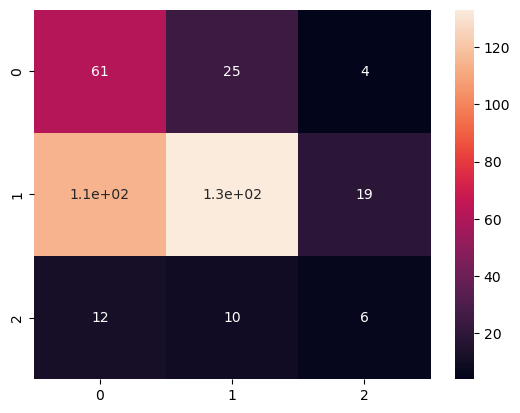

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(mat1, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [39]:
from sklearn.metrics import precision_recall_fscore_support

In [40]:
precision,recall,fscore,support = precision_recall_fscore_support(final_original,final_prediction,labels=[0,1,2])

In [41]:
precision

array([0.32620321, 0.79166667, 0.20689655])

In [42]:
recall

array([0.67777778, 0.5       , 0.21428571])

In [43]:
fscore

array([0.44043321, 0.61290323, 0.21052632])

In [44]:
support

array([ 90, 266,  28])